In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as Trans
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch
import torch.nn as nn

from PIL import Image
import requests
from io import BytesIO
import cv2 as cv
from google.colab.patches import cv2_imshow

In [3]:
# Define image size for preprocessing; and batch size
image_size = 64
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [4]:
dataroot = "/content/drive/MyDrive/disney-dataset/test"

# Creating a DataLoader for the test dataset with specified transformations
testloader = datasets.ImageFolder(dataroot, transform = Trans.Compose([
           Trans.Resize(image_size),
           Trans.CenterCrop(image_size),
           Trans.ToTensor(),
           Trans.Normalize(*stats)]))

# Creating batches of test data with DataLoader
testloader = DataLoader(testloader, batch_size, shuffle = True, num_workers = 3, pin_memory = True)

total_test_images = len(testloader.dataset)
print("Total number of images in the test dataset:", total_test_images)

Total number of images in the test dataset: 376


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
# Categories for the Disney characters
classes = ("donald", "mickey", "minion", "olaf", "pooh")

In [6]:
# Define a neural network for image classification
class Net(nn.Module):
  def __init__(self):
      super(Net, self).__init__()

      # Convolutional layers for feature extraction
      self.cnn_layers = nn.Sequential(
          nn.Conv2d(3, 4, kernel_size = 3, stride = 1, padding = 1),
          nn.BatchNorm2d(4),
          nn.ReLU(inplace = True),
          nn.MaxPool2d(kernel_size = 2, stride = 2),
          nn.Conv2d(4, 4, kernel_size = 3, stride = 1, padding = 1),
          nn.BatchNorm2d(4),
          nn.ReLU(inplace = True),
          nn.MaxPool2d(kernel_size = 2, stride = 2))

      # Fully connected layers for classification
      self.linear_layers = nn.Sequential(
          nn.Linear(4 * 16 * 16, 5))

  def forward(self, x):
      # Forward pass through the network
      x = self.cnn_layers(x)
      x = x.view(x.size(0), -1)
      x = self.linear_layers(x)
      return x

In [7]:
# Check if CUDA (GPU support) is available, and set the device accordingly, else use the CPU
if torch.cuda.is_available():
  torch.device("cuda")
else:
  torch.device("cpu")

In [9]:
# Load the model for evaluation or predictions
loaded_model = Net()
loaded_model.load_state_dict(torch.load("/content/drive/MyDrive/pretrained_model.pth"))

<All keys matched successfully>

In [10]:
tot_images = 0
corr_images = 0

# Move the loaded model to the GPU if available
loaded_model = loaded_model.cuda()

loaded_model.eval()

with torch.no_grad():
    for images, labels in testloader:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        # Forward pass using the loaded model
        output = loaded_model(images)

        # Calculate probabilities and predictions
        ps = torch.exp(output)
        pred_labels = torch.argmax(ps, dim = 1)

        # Update counters
        corr_images += torch.sum(pred_labels == labels).item()
        tot_images += labels.size(0)

print("\nNumber of tested images:", tot_images)
print("Number of correctly classified images:", corr_images)
print("Model accuracy: {:.3f}%".format(corr_images / tot_images * 100))


Number of tested images: 376
Number of correctly classified images: 331
Model accuracy: 88.032%


Original image


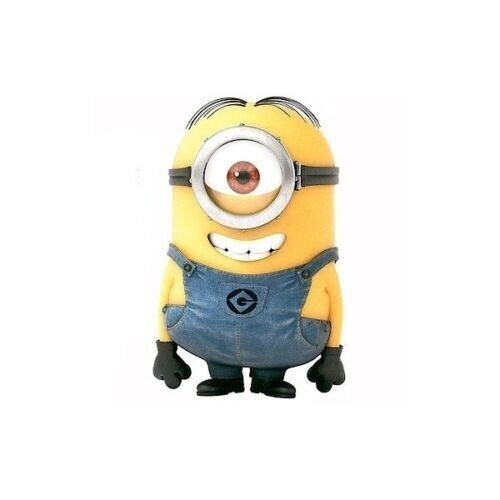


Preprocessed image


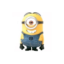


Predicted class: minion


In [11]:
# Some images for you to choose
don = "https://easydrawingart.com/wp-content/uploads/2019/08/How-to-Draw-Donald-Duck.jpg"  # donald
poo = "https://static.wikia.nocookie.net/vsbattles/images/d/d8/Download-Winnie-The-Pooh-PNG-File.png/revision/latest/scale-to-width-down/240?cb=20200924000600"  # pooh
ola = "https://static.wikia.nocookie.net/disney/images/5/53/Profile_-_Olaf.jpeg/revision/latest?cb=20200221075027"  # olaf
mic = "https://static.wikia.nocookie.net/elsagate/images/d/d4/Mickey_Mouse.png/revision/latest?cb=20220429154331"  # mickey
min = "https://i.ebayimg.com/images/g/OgsAAOSw9dNjf0EQ/s-l1600.jpg"  # minion

# Link to the image
image_url = min

# Download the image
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

# Convert the image to a NumPy array (OpenCV format)
img_np = cv.cvtColor(np.array(img), cv.COLOR_RGB2BGR)

# Display the image
print("Original image")
cv2_imshow(img_np)

# Convert the image to RGB
img = img.convert("RGB")

# Preprocess the image
transform = Trans.Compose([
           Trans.Resize(image_size),
           Trans.CenterCrop(image_size),
           Trans.ToTensor(),
           Trans.Normalize(*stats)])

# Apply the transformation to the image
img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0)  # Add a batch dimension

#------------------------------------------------------------------------#

# Convert the img_tensor to a NumPy array
img_np = img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Denormalize the image
img_np = img_np / 2 + 0.5

# Convert to uint8
img_np = (img_np * 255).astype(np.uint8)

# Display the preprocessed image
print("\nPreprocessed image")
cv2_imshow(cv.cvtColor(img_np, cv.COLOR_BGR2RGB))

#-----------------------------------------------------------------------#

# Move the tensor to GPU if available
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

# Forward pass using the loaded model
output = loaded_model(img_tensor)
ps = torch.exp(output)

# Get the predicted label
pred_label = torch.argmax(ps, dim = 1).item()

# Display the result
print("\nPredicted class:", classes[pred_label])